In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, OrdinalEncoder
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression

from sklearn import set_config
import os

import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, StratifiedGroupKFold
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, LGBMRegressor, Dataset
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import gc
import re

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [2]:
ITERATIONS = None
TASK_TYPE = "GPU"

In [ ]:
from pathlib import Path
from datetime import datetime
import sys

# Define the base directory
base_dir = Path.cwd().resolve().parents[1]

# Define subdirectories
data_dir = base_dir / "data"
model_dir = base_dir / "models"
notebooks_dir = base_dir / "notebooks"

# Create a timestamped directory for AutoGluon
# autogluon_folder = base_dir / "AutogluonModels" / f"ag-{datetime.now():%Y%m%d_%H%M%S}"

# Append base_dir to sys.path
sys.path.append(str(base_dir))

# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Config</span>

In [3]:
import joblib
class Config:
    
    state = 42
    n_splits = 10
    early_stop = 200
        
    target = 'Premium Amount'
    
    train = pd.read_csv(data_dir/'train.csv', index_col='id')
    test = pd.read_csv(data_dir/'test.csv', index_col='id')
    nonlog_train , nonlog_test = joblib.load("nonlog_feature/cat_non_loged.pkl")
    
    train['nonlog'] = nonlog_train
    test['nonlog'] = nonlog_test
    
    submission = pd.read_csv(data_dir/'sample_submission.csv')

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'N'
    feature_eng = 'Y'
    missing = 'Y'

# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Data Transformation</span>

In [4]:
class Transform(Config):
    
    def __init__(self):
        super().__init__()
        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, self.train_org], ignore_index=True).drop_duplicates()
            self.train.reset_index(drop=True, inplace=True)

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        
        if self.missing == 'Y':
            self.missing_values()
            
        self.train_raw = self.train.copy()
        
        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)
            
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
            
        if self.outliers == 'Y':    
            self.remove_outliers()
            
        if self.log_trf == 'Y':
            self.log_transformation()
            
        if self.scaler_trf == 'Y':
            self.scaler()
            
        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()
        self.encode()
        
        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()
        
    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype('category')
        self.test[self.cat_features] = self.test[self.cat_features].astype('category')

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(self.train[f].nunique())

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        
        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)
        
        return self.train, self.train_enc, self.y, self.test, self.test_enc, self.cat_features
    
    def encode(self):
        data = pd.concat([self.test, self.train])
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')
        
        scaler = StandardScaler()
        data[self.num_features + [self.target]] = scaler.fit_transform(data[self.num_features + [self.target]])
        
        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
            
    def new_features(self, data): 
        data['Policy Start Date'] = pd.to_datetime(data['Policy Start Date'])
        data['Year'] = data['Policy Start Date'].dt.year
        data['Day'] = data['Policy Start Date'].dt.day
        data['Month'] = data['Policy Start Date'].dt.month
        data["Weekday"] = data["Policy Start Date"].dt.weekday
        data.drop('Policy Start Date', axis=1, inplace=True)
        return data

    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target]) 
        
        return self
    
    def distribution(self):
        num_features = self.num_features + [self.target]
        print(Style.BRIGHT+Fore.GREEN+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=len(num_features), ncols=2, figsize=(15, len(num_features)*5))

        for (ax_r, ax_n), col in zip(axes, num_features):

            ax_r.set_title(f'{col} ($\mu=$ {self.train_raw[col].mean():.2f} and $\sigma=$ {self.train_raw[col].std():.2f} )')
            ax_r.hist(self.train_raw[col], bins=30, color='#3cb371')
            ax_r.axvline(self.train_raw[col].mean(), color='r', label='Mean')
            ax_r.axvline(self.train_raw[col].median(), color='y', linestyle='--', label='Median')
            ax_r.legend()

            ax_n.set_title(f'{col} Normalized ($\mu=$ {self.train_enc[col].mean():.2f} and $\sigma=$ {self.train_enc[col].std():.2f} )')
            ax_n.hist(self.train_enc[col], bins=30, color='#3cb371')
            ax_n.axvline(self.train_enc[col].mean(), color='r', label='Mean')
            ax_n.axvline(self.train_enc[col].median(), color='y', linestyle='--', label='Median')
            ax_n.legend()
        
    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True) 
        
    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(self.train[self.num_features])
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self
    
    def missing_values(self):

        self.train[self.cat_features] = self.train[self.cat_features].fillna('None')
        self.test[self.cat_features] = self.test[self.cat_features].fillna('None')
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        return df


Histograms of distribution



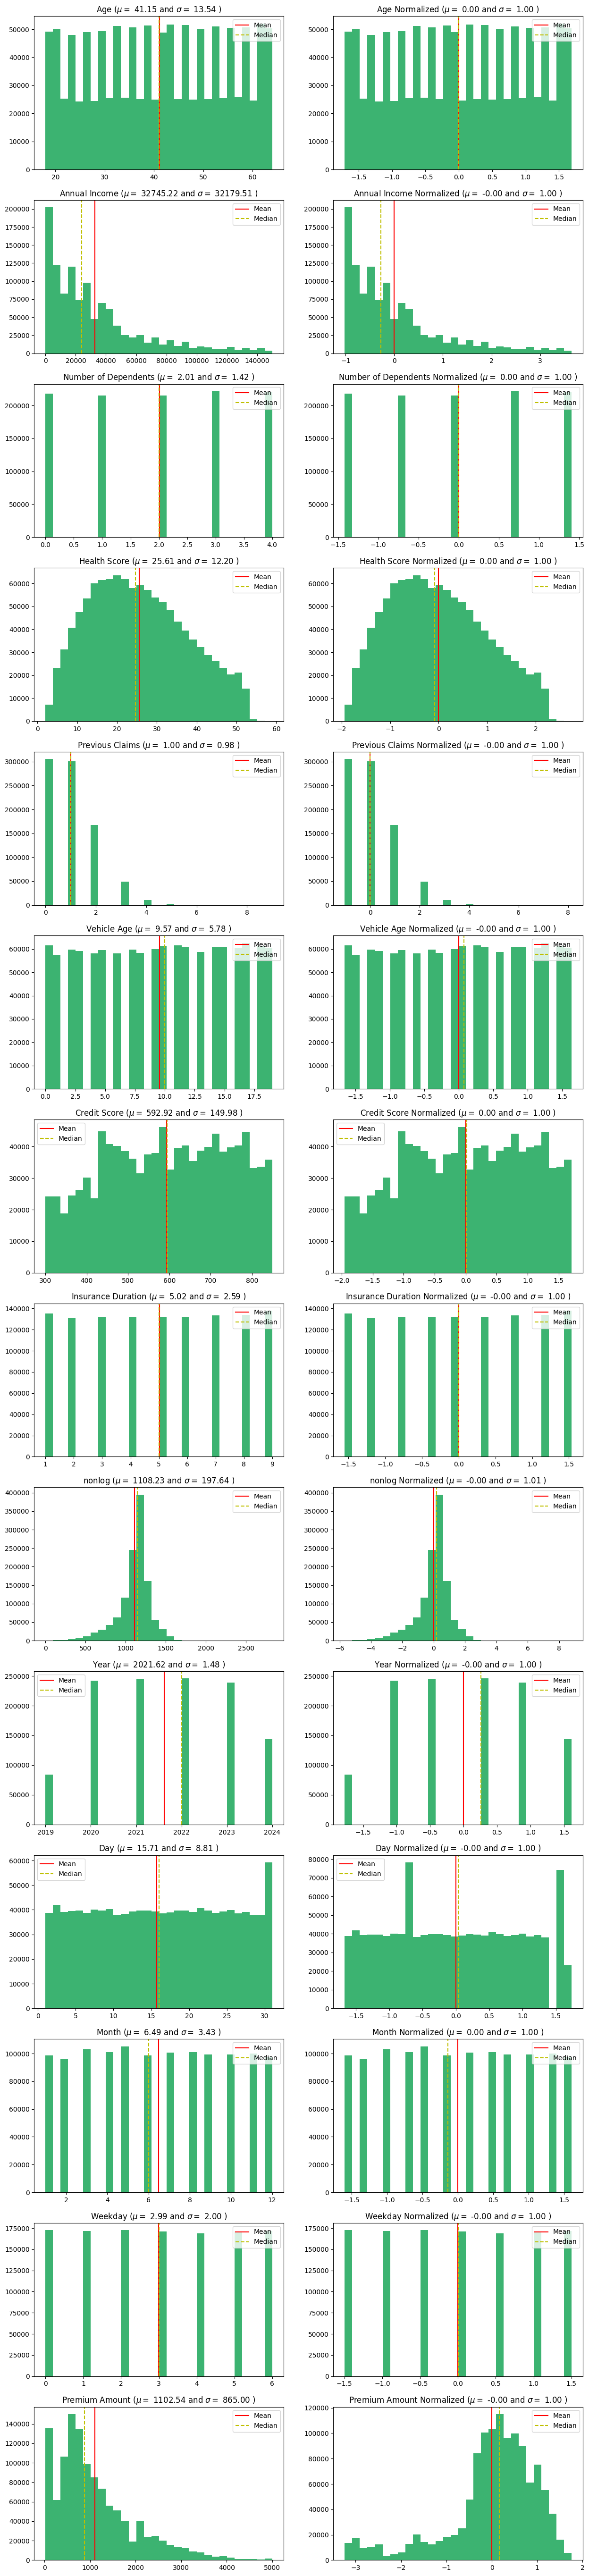

In [5]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Model Training</span>

In [6]:
models = {
    # 'NN': [_,
    #        True],
    'CAT': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': Config.early_stop,
                                  'eval_metric': "RMSE",
                                  'task_type':TASK_TYPE,  # Enable GPU
                                  'n_estimators' : 2000 if ITERATIONS is None else ITERATIONS
                              }),
            True],
    'CAT2': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': Config.early_stop,
                                  'eval_metric': "RMSE",
                                  'n_estimators' : 3000 if ITERATIONS is None else ITERATIONS,
                                 'objective': 'RMSE', 
                                 'depth': 11,
                                 'min_data_in_leaf': 78,
                                 'l2_leaf_reg': 6.628202811121375,
                                 'max_bin': 8000,
                                 'learning_rate': 0.01,
                                  'task_type':TASK_TYPE,  # Enable GPU
                              }),
            True],
    'CAT3': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': 200,
                                  'eval_metric': "RMSE",
                                  'objective': 'RMSE', 
                                  'depth': 11,
                                  'min_data_in_leaf': 72, 
                                  'l2_leaf_reg': 2.005119577280367,
                                  "iterations" : 3000 if ITERATIONS is None else ITERATIONS,
                                  'learning_rate': 0.01,
                                  'max_bin': 8000,
                                  'task_type':TASK_TYPE,  # Enable GPU
                             }),
        True],
    'CAT4': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': 200,
                                  'eval_metric': "RMSE",
                                  'objective': 'RMSE', 
                                  'depth': 13, 
                                  'subsample': 0.9998449533801151,
                                  'min_data_in_leaf': 63,
                                  'l2_leaf_reg': 0.3242106539167982,
                                  "iterations" : 3000 if ITERATIONS is None else ITERATIONS,
                                  'learning_rate': 0.01,
                                  'max_bin': 8000,
                                  'bootstrap_type': 'Poisson',
                                  'task_type':TASK_TYPE,  # Enable GPU
                         }),
            True],
    'XGB': [XGBRegressor(**{'tree_method': 'hist',
                             'n_estimators': 2000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                           }),
            True],
    'XGB2': [XGBRegressor(**{'tree_method': 'hist',
                             'n_estimators': 2000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            'booster': 'gbtree',
                            'max_depth': 9,
                            'learning_rate': 0.0031740845858378402, 
                            'min_child_weight': 16,
                            'subsample': 0.8666770334099294,
                            'reg_alpha': 0.191908421033219,
                            'reg_lambda': 0.7995814007464592,
                            'colsample_bytree': 0.9669446980405391,
                            'random_state': 42,
                            'objective': 'reg:squarederror',
                            'n_jobs': -1,
                           }),
            True],
    'XGB3': [XGBRegressor(**{'booster': 'gbtree', 
                             'max_depth': 9,
                             'min_child_weight': 13,
                             'subsample': 0.8626964099130539,
                             'reg_alpha': 0.058057084885141746,
                             'reg_lambda': 0.6326297976784753,
                             'colsample_bytree': 0.8940282896063437,
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             'tree_method': 'hist',
                             'n_estimators': 2000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            }),
             True],
    'XGB4': [XGBRegressor(**{'booster': 'gbtree',
                             'max_depth': 8,
                             'min_child_weight': 17,
                             'subsample': 0.8926967587245219,
                             'reg_alpha': 0.2968941900087133,
                             'reg_lambda': 0.8270727714379025,
                             'colsample_bytree': 0.9318890724874014,
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             'tree_method': 'hist',
                             'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            }),
             True],
    'XGB5': [XGBRegressor(**{'booster': 'gbtree', 
                             'max_depth': 9,
                             'min_child_weight': 13,
                             'subsample': 0.8950190330733485, 
                             'reg_alpha': 0.3530275785494063,
                             'reg_lambda': 0.9564526039891854, 
                             'colsample_bytree': 0.8488129245455193,
                             'random_state': 42,
                             'objective': 'reg:squarederror',
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             'tree_method': 'hist',
                             'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            }),
             True],
    'LGBM': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                               'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              }),
             True],
    'LGBM2': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                               'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              'max_depth': 9,
                              'num_leaves': 722,
                              'min_child_samples': 27,
                              'min_child_weight': 14,
                              'colsample_bytree': 0.49498912736255835,
                              'reg_alpha': 0.3428923649002299, 
                              'reg_lambda': 0.6429288241470125,
                               'learning_rate': 0.01,
                              }),
             True],
    'LGBM3': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                               'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              'learning_rate': 0.01,
                               'max_bin': 8000,
                               'max_depth': 8, 
                               'num_leaves': 796,
                               'min_child_samples': 21,
                               'min_child_weight': 11,
                               'colsample_bytree': 0.48551477424501904, 
                               'reg_alpha': 0.44307695050069845, 
                               'reg_lambda': 0.9310703189038081, 
                              }),
             True],
    'LGBM4': [LGBMRegressor(**{'objective': 'regression_l2',
                               'metric': 'rmse',
                               'max_depth': 10, 
                               'num_leaves': 133,
                               'min_child_samples': 18, 
                               'min_child_weight': 14, 
                               'colsample_bytree': 0.4997666632394159, 
                               'reg_alpha': 0.2813104886322961, 
                               'reg_lambda': 0.8049716583639613,
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'goss',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                              'learning_rate': 0.01,
                              }),
              True],
    'HGB': [HistGradientBoostingRegressor(**{'max_depth': 13,
                                             'learning_rate': 0.08814188960134894,
                                             'loss': 'squared_error',
                                             'l2_regularization': 1.518602886724097,
                                             'min_samples_leaf': 37,
                                             'max_leaf_nodes': 40,
                                             'max_iter': 3000 if ITERATIONS is None else ITERATIONS,
                                             'random_state': 42,
                                             'early_stopping': 200
                                            }),
            True],
    'HGB2': [HistGradientBoostingRegressor(**{'max_depth': 13,
                                              'learning_rate': 0.026862116662879427,
                                              'loss': 'squared_error', 
                                              'l2_regularization': 0.040027066827640706,
                                              'min_samples_leaf': 33,
                                              'max_leaf_nodes': 39,
                                             'max_iter': 3000 if ITERATIONS is None else ITERATIONS,
                                             'random_state': Config.state,
                                             'early_stopping': Config.early_stop
                                            }),
            True],
}

In [7]:
class Model(Config):
    
    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        self.TEST_preds = pd.DataFrame()
    def train(self):
        
        folds = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.state)
 
        for model_name, [model, training] in tqdm(self.models.items()):
            
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB']):
                    self.X = X
                    self.test = test
 
                else:
                    self.X = X_enc
                    self.test = test_enc
                    
                if 'NN' in model_name:
                    for n_fold, (train_id, valid_id) in enumerate(folds.split(self.X, self.y)):

                        X_train_cats = self.X.loc[train_id, cat_features]
                        X_train_nums = self.X.loc[train_id, t.num_features]
                        y_train = self.y.loc[train_id].values

                        X_val_cats = self.X.loc[valid_id, cat_features]
                        X_val_nums = self.X.loc[valid_id, t.num_features]
                        y_val = self.y.loc[valid_id]

                        X_test_cats = self.test[cat_features]
                        X_test_nums = self.test[t.num_features]
        
                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val_cats.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')
                        
                        model = build_model()                        
                        keras.utils.set_random_seed(self.state)
                        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        model.fit([X_train_cats,X_train_nums], y_train, 
                                  validation_data=([X_val_cats, X_val_nums], y_val),
                                  epochs=20,
                                  batch_size=1000,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=1),
                                             keras.callbacks.EarlyStopping(patience=3)
                                            ])
                        
                        y_pred_val = model.predict([X_val_cats, X_val_nums])
                        test_pred = model.predict([X_test_cats, X_test_nums])
                        
                        score = mean_squared_error(y_val, y_pred_val, squared=False)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score
                        
                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)
                        
                else:
                    for n_fold, (train_id, valid_id) in enumerate(folds.split(self.X, self.y)):
                        X_train, y_train = self.X.iloc[train_id], self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id], self.y.iloc[valid_id]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)], 
                                      verbose = False
                                     )

                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)],
                                      verbose=False
                                      ) 

                        elif "LGBM" in model_name:
                             model.fit(X_train, y_train, 
                                       eval_set = [(X_val, y_val)], 
                                       callbacks = [log_evaluation(0),
                                                    early_stopping(self.early_stop, verbose = False)
                                                   ])  

                        else:
                            model.fit(X_train, y_train)

                        y_pred_val = model.predict(X_val)
                        test_pred = model.predict(self.test)
                       
                        score = mean_squared_error(y_val, y_pred_val, squared=False)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred
                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                self.TEST_preds = self.TEST_preds.groupby(level=0).mean()

                self.OOF_preds[f'{model_name}'].to_csv(f'{model_name}_oof.csv', index=False)
                self.TEST_preds[f'{model_name}'].to_csv(f'{model_name}_test.csv', index=False)
            
            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/nonlog/{model_name}_oof.csv')
                self.TEST_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/nonlog/{model_name}_test.csv')
                
                for n_fold, (train_id, valid_id) in enumerate(folds.split(self.OOF_preds[f'{model_name}'], self.y)):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = mean_squared_error(y_val, y_pred_val, squared=False)
                    
            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], self.TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, self.TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return self.TEST_preds
    
    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        model = LinearRegression()
        skf = KFold(n_splits=self.n_splits, random_state=self.state, shuffle=True)

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_pred_probs = model.predict(X_val)
            oof_pred[val_idx] = y_pred_probs
            test_pred += model.predict(test) / self.n_splits
            
            score = mean_squared_error(y_val, y_pred_probs, squared=False)
            scores.append(score)
                   
        return np.mean(scores), oof_pred, test_pred
    
    def result(self):
               
        plt.figure(figsize=(18, 6))
        hbars = plt.bar(self.scores.index, self.scores.Score, color='#3cb371', width=0.5)
        plt.bar_label(hbars, fmt='%.5f')
        plt.ylim(1.03,1.034)
        plt.xlabel('Models')
        plt.ylabel('Score')              
        plt.show()

        y = np.expm1(self.y).sort_index()
        self.OOF_preds['Ensemble'] = np.expm1(self.OOF_preds['Ensemble']).sort_index()
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')

        axes[1].scatter(self.OOF_preds['Ensemble'], y - self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')

        plt.tight_layout()
        plt.show()

In [ ]:
model = Model(X, X_enc, y, test, test_enc, models)
TEST_preds = model.train()

  0%|          | 0/15 [00:00<?, ?it/s]

CAT
Fold 1


# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Submission</span>

In [ ]:
submission = Config.submission
submission[Config.target] = np.expm1(TEST_preds['Ensemble'].values)
submission.to_csv("submission.csv", index=False)

display(submission.head())

In [ ]:
plt.figure(figsize=(14, 6))
submission[Config.target].hist(color='#3cb371', bins=30)
plt.show()